# Computing the mean using `Queue`

In this notebook, we compute the mean of an array of random numbers. This is similar to the notebook `mean_demo0`, but we use the `Queue` connection instead of a `Pipe`. The `Queue` connection is built on top of `Pipe` and has more functionality.

Rather than import NumPy, we will use the `%pylab` magic command, which essentially is equivalent

    from numpy import *
    from scipy import *
    from matplotlib.pyplot import *

In [1]:
%matplotlib notebook
%pylab
import time
import multiprocessing as mp
import pandas

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
N = 2**28
x = random.rand(N)
print("Memory usage {:.2f} GB".format(N*8/1024**3))

Memory usage 2.00 GB


In [3]:
def vsum(x,q):
    q.put(sum(x))
    
def compute_mean(x,np):
    N = len(x)
    jobs = []
    q = mp.Queue()
    for i in range(np):
        i1 = int(i*N/np)
        i2 = int((i+1)*N/np)
        job = mp.Process(target=vsum,args=[x[i1:i2],q])
        jobs.append(job)
        
    for job in jobs:
        job.start()
    
    for job in jobs:
        job.join()
        
    s = 0
    while not q.empty():
        s += q.get()
        
    return s/N    

In [4]:
# Use 'timeit' loop
procs = 2**arange(0,6)
tdata = empty(procs.shape)
for i,np in enumerate(procs):
    tr = %timeit -n 1 -r 5 -q -o pass; compute_mean(x,np)
    tdata[i] = tr.best    

In [5]:
df = pandas.DataFrame({'Procs' : procs, 'Time' : tdata})

fstr = {'Procs' : "{:d}".format, 'Time' : "{:.2f}".format}
df.style.format(fstr)

,Procs,Time
0,1,1.26
1,2,0.58
2,4,0.32
3,8,0.23
4,16,0.28
5,32,0.30


<IPython.core.display.Javascript object>


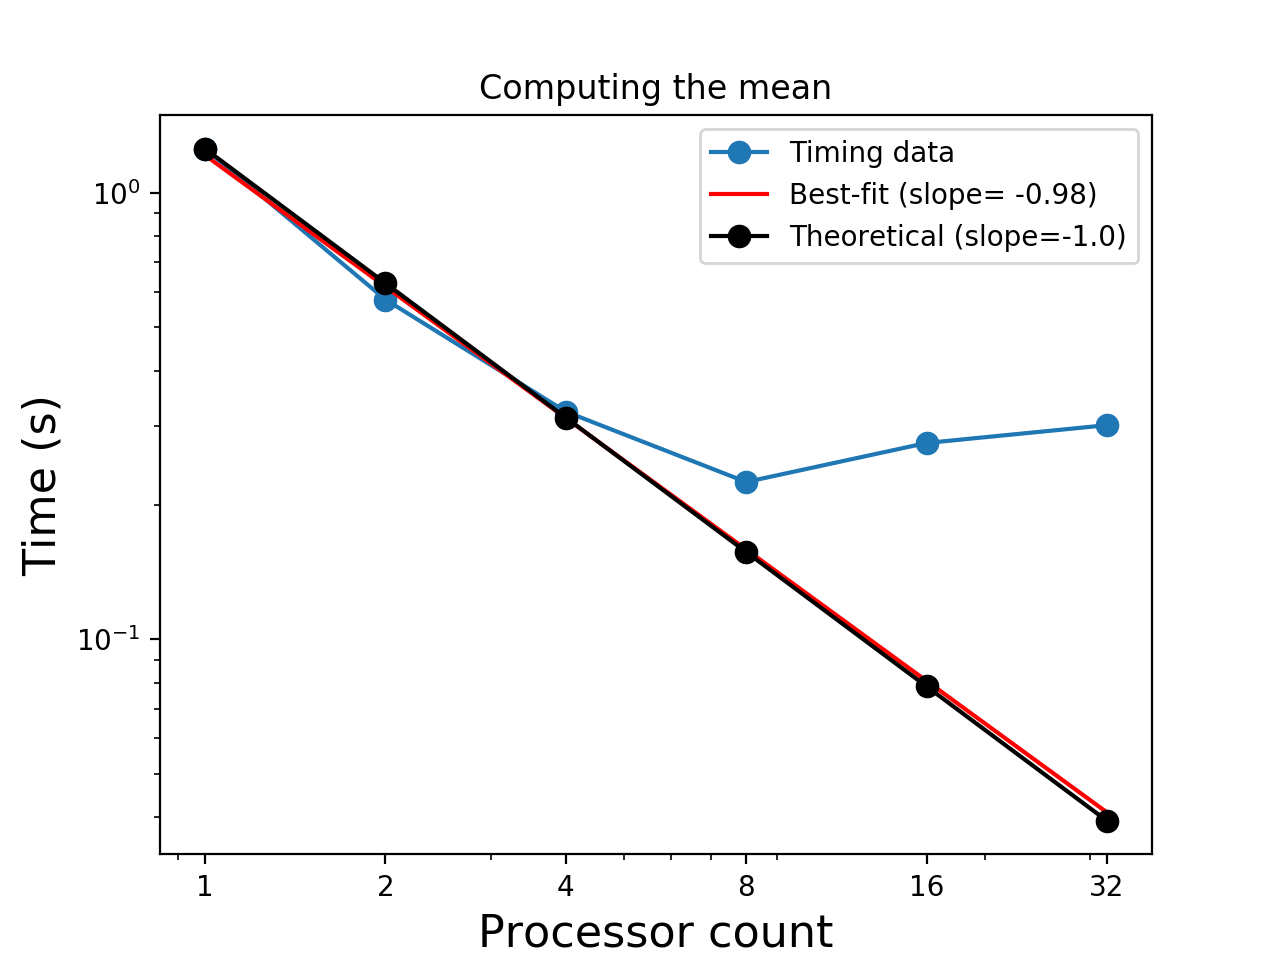

In [6]:
figure(1)
clf()

# Plot computed data
loglog(df['Procs'],df['Time'],'.-',markersize=15,label='Timing data')

# Only fit the data to the first few data points.
max_procs = 4
imax = int(log2(max_procs)) + 1
c = polyfit(log(procs[:imax]),log(df['Time'][:imax]),1)

# Plot best fit line; store label for legend
loglog(procs,exp(polyval(c,log(procs))),'r-',label='Best-fit (slope={:6.2f})'.format(c[0]))

# Theoretical line : T = T_0/procs
loglog(procs,df['Time'][0]/procs,'k.-',markersize=15,label='Theoretical (slope=-1.0)')

# Make nice tick marks and add a legend, labels, title.
pstr = (['{:d}'.format(int(p)) for p in procs])
xticks(procs,pstr);

legend()

xlabel('Processor count',fontsize=16)
ylabel('Time (s)',fontsize=16)
title('Computing the mean');